In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GAE, GCNConv

# Load datasets
labeled_data = pd.read_csv('3k_labeled_extracted.csv')
unlabeled_data = pd.read_csv('30k_unlabeled_extracted.csv')

# Prepare features and labels for labeled data
X_labeled = labeled_data.drop(columns=['text_', 'label']).values
y_labeled = labeled_data['label'].values

# For unlabeled data, use only features
X_unlabeled = unlabeled_data.drop(columns=['text_']).values

# Encode labels (e.g., 'CG' as 0, 'OR' as 1)
label_encoder = LabelEncoder()
y_labeled_encoded = label_encoder.fit_transform(y_labeled)

# Concatenate both datasets for graph creation
X_combined = np.vstack((X_labeled, X_unlabeled))

In [8]:
from sklearn.neighbors import kneighbors_graph

def create_graph(X, n_neighbors=5):
    # Create a knearest neighbor graph
    adj_matrix = kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
    edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
    x = torch.tensor(X, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

# Create graph data for labeled and unlabeled datasets
graph_data = create_graph(X_combined, n_neighbors=5)


In [10]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 8)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return torch.sigmoid(torch.matmul(z[edge_index[0]], z[edge_index[1]].T))

# Instantiate model
model = GCN(input_dim=X_combined.shape[1])


In [24]:
import torch
from torch.optim import Adam
import time

# Set the device to CPU
device = torch.device('cpu')

def train_gae(model, data, epochs=20, lr=0.01, early_stopping_patience=5, log_frequency=2):
    # Move model to CPU
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience_counter = 0

    model.train()
    start_time = time.time()  # Timing for monitoring

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        z = model.encode(data.x.to(device), data.edge_index.to(device))  # Ensure data is on CPU
        loss = model.decode(z, data.edge_index.to(device)).mean()

        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Log loss at specified intervals
        if epoch % log_frequency == 0:
            print(f'Epoch {epoch}: Loss {loss.item():.4f}')

        # Early stopping check
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0  # Reset counter if we improved
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")

# Train the model with the CPU
train_gae(model, graph_data)

Epoch 0: Loss 0.5005
Epoch 2: Loss 0.5005
Epoch 4: Loss 0.4991
Epoch 6: Loss 0.4972
Epoch 8: Loss 0.4951
Epoch 10: Loss 0.4932
Epoch 12: Loss 0.4901
Epoch 14: Loss 0.4877
Epoch 16: Loss 0.4831
Epoch 18: Loss 0.4767
Training completed in 1338.69 seconds.


In [30]:
# After completing the first 20 epochs
torch.save(model.state_dict(), 'model_checkpoint.pth')  # Save model state

In [43]:
# Code Cell 5 - Updated for Embedding Extraction and Classification
import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Step 1: Extract embeddings for labeled data using the complete graph
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Get embeddings for the full graph, we will use these for the classifier
    embeddings = model.encode(graph_data.x.to(device), graph_data.edge_index.to(device)).cpu().numpy()

# Step 2: Prepare labels for the classifier
labels = y_labeled_encoded  # Use encoded labels from labeled data

# Step 3: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(embeddings[:len(y_labeled_encoded)], labels, test_size=0.2, random_state=42)

# Step 4: Train a classifier (e.g., Random Forest)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = classifier.predict(X_test)

# Step 6: Evaluate the classifier
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Classification Report:
               precision    recall  f1-score   support

          CG       0.75      0.79      0.77       288
          OR       0.80      0.76      0.78       312

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.77       600
weighted avg       0.78      0.78      0.78       600

Confusion Matrix:
 [[227  61]
 [ 74 238]]
Accuracy Score: 0.775
F1 Score: 0.7750894050500308


In [49]:
# Code Cell 6 - Predicting Labels for Unlabeled Data

# Step 1: Extract embeddings for unlabeled data using the same graph model
with torch.no_grad():
    num_labeled = len(y_labeled_encoded)
    all_embeddings = model.encode(
        graph_data.x.to(device), 
        graph_data.edge_index.to(device)  # Use the full edge_index
    ).cpu().numpy()
labeled_embeddings = all_embeddings[:num_labeled]
unlabeled_embeddings = all_embeddings[num_labeled:]
unlabeled_predictions = classifier.predict(unlabeled_embeddings)
unlabeled_data['predicted_label'] = label_encoder.inverse_transform(unlabeled_predictions)
unlabeled_data.to_csv('unlabeled_data_with_predictions.csv', index=False)

# Print out some of the predictions for verification
print(unlabeled_data[['text_', 'predicted_label']].head())

                                               text_ predicted_label
0                                              NOTE:              CG
1  Very bad experience with this iPhone xr phone....              OR
2  Amazing phone with amazing camera coming from ...              OR
3  So I got the iPhone XR just today. The product...              OR
4  I've been an android user all my life until I ...              OR


Reconstruction Loss: 0.46811333298683167


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.6105489134788513


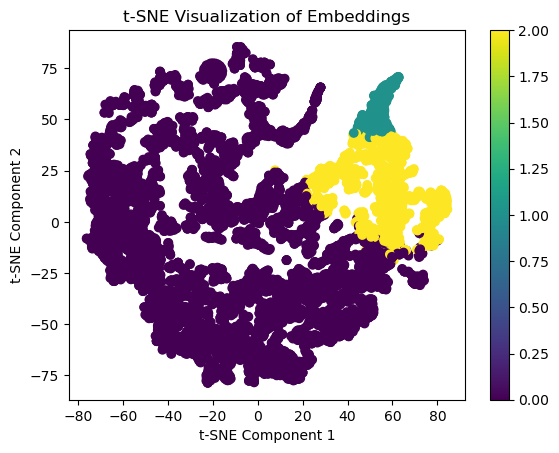

In [36]:
import torch
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
model.eval()  
with torch.no_grad():
    z = model.encode(graph_data.x, graph_data.edge_index)  # Get embeddings

# 1. Reconstruction Loss
recon_loss = model.decode(z, graph_data.edge_index).mean()  # Calculate reconstruction loss
print(f'Reconstruction Loss: {recon_loss.item()}')

# 2. Clustering and Silhouette Score
n_clusters = 3  # You can change this based on your data's characteristics
kmeans = KMeans(n_clusters=n_clusters)  
labels = kmeans.fit_predict(z.cpu().numpy())
sil_score = silhouette_score(z.cpu().numpy(), labels)
print(f'Silhouette Score: {sil_score}')

# 3. t-SNE Visualization
z_embedded = TSNE(n_components=2).fit_transform(z.cpu().numpy())
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

In [ ]:
#########
import torch
from torch.optim import Adam
import time
device = torch.device('cpu')
def train_gae(model, data, epochs=50, lr=0.01, early_stopping_patience=10, log_frequency=5):
    # Move model to CPU
    model.to(device)
   
    optimizer = Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience_counter = 0
    model.train()
    start_time = time.time()  # Timing for monitoring

    for epoch in range(epochs):
        optimizer.zero_grad() 
        # Forward pass
        z = model.encode(data.x.to(device), data.edge_index.to(device))  # Ensure data is on CPU
        loss = model.decode(z, data.edge_index.to(device)).mean()
        # Backward pass
        loss.backward()
        optimizer.step()       
        # Log loss at specified intervals
        if epoch % log_frequency == 0:
            print(f'Epoch {epoch}: Loss {loss.item()}')
        # Early stopping check
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0  # Reset counter if we improved
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")
train_gae(model, graph_data)



#########
import pandas as pd
import torch
from torch_geometric.data import Data

# Load your test dataset
test_df = pd.read_csv('test_data.csv')  # Update with your actual test dataset path
y_true = test_df['rating'].to_numpy()  # Replace with the correct column name for true labels

# Assuming you have a method to preprocess your text data
# x = preprocess_text(test_df['text_'])  # Replace with your preprocessing function
x = ...  # This should be your feature matrix (like BERT embeddings)

# Define your graph edges for the test set (this depends on your dataset and how you want to represent it)
edge_index = ...  # Create edge indices (for example, an adjacency list)

# Create the graph data object for testing
graph_data_test = Data(x=torch.tensor(x, dtype=torch.float), edge_index=edge_index)



##########
from sklearn.metrics import mean_squared_error, accuracy_score

def evaluate_model(model, data):
    model.eval()  # Set the model to evaluation mode
    y_true = []  # Ground truth labels
    y_pred = []  # Model predictions

    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)  # Get embeddings
        predictions = model.decode(z, data.edge_index)  # Get predictions

        # Collect predictions and true labels
        for i in range(len(data.x)):
            y_true.append(data.y[i].item())  # Replace with your ground truth label extraction
            y_pred.append(predictions[i].item())  # Convert prediction to list

    # Evaluate using appropriate metrics
    mse = mean_squared_error(y_true, y_pred)
    accuracy = accuracy_score(y_true, [1 if p >= 0.5 else 0 for p in y_pred])  # Assuming binary classification with 0.5 threshold

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

# Load your labeled dataset (make sure it’s preprocessed and feature extracted)
# Example: graph_data_test is your preprocessed and feature-extracted labeled dataset
evaluate_model(model, graph_data_test)